### Imports and Configs

In [3]:
import json
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage
from pathlib import Path

from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

OUTPUT_DATA = project_root / parser.get("data_paths", {}).get("output_data")

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

### Selecting Processed Samples with sample size = 64

In [8]:
# Loading Filtered Columns
meta_donor_df_filtered = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path("meta_donor_filtered.csv"))
meta_donor_df_filtered["gene_expression_values"]=meta_donor_df_filtered["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df_filtered["gene_expression_values"][0][0])

# Loading mean and std stats of the filtered samples
stats_df = load_df_from_csv(OUTPUT_DATA / Path('df_stats.csv'))
stats_df.head(3)

3.4665720939923


,brain_region,gene_id,sum_expression,effect_size_8,p-value_8,power_8,t_stat_8,effect_size_16,p-value_16,power_16,...,power_256,t_stat_256,effect_size_512,p-value_512,power_512,t_stat_512,effect_size_1024,p-value_1024,power_1024,t_stat_1024
0,4012,2541,7305.189875,0.723958,0.039062,0.579479,31.0,0.170152,0.231873,0.159962,...,0.988638,21436.0,0.179155,8.732317e-07,0.991882,81676.0,0.285270,1.100408e-22,1.000000,354526.0
1,4013,1259,9883.385544,0.576161,0.125000,0.431013,27.0,-0.327191,0.798126,0.001882,...,0.991683,21943.0,0.152272,4.490161e-06,0.963761,80536.0,0.088223,1.216660e-05,0.880289,302356.0
2,4013,2541,12655.801370,0.716566,0.054688,0.572157,30.0,0.205089,0.247711,0.194567,...,0.999900,22748.0,0.324791,3.459548e-14,1.000000,90748.0,0.264883,9.052327e-20,1.000000,347825.0


### Standardizing Data Before Applying UnSupervised Techniques

In [9]:
# Load dataset
df =  stats_df.copy()

# Extract effect size columns dynamically
effect_size_cols = [col for col in df.columns if "effect_size" in col]
effect_size_data = df[effect_size_cols]

# Normalize effect sizes
scaler = StandardScaler()
effect_size_scaled = scaler.fit_transform(effect_size_data)

### Elbow Method

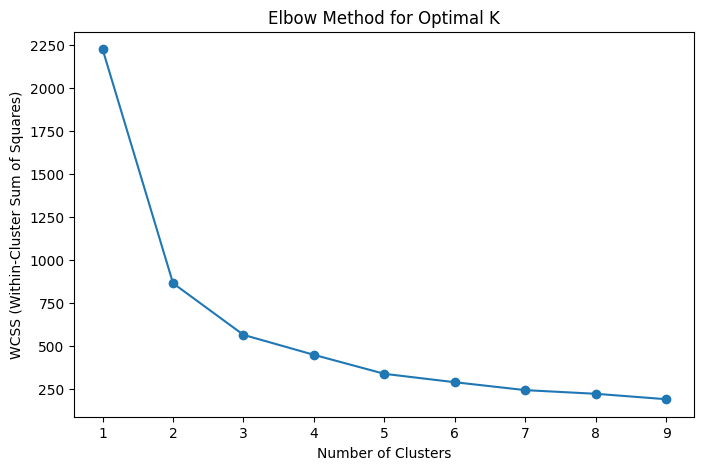

In [10]:
# Determine optimal clusters using the Elbow Method
wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(effect_size_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker="o")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [11]:
# Choose optimal K (e.g., 3 based on the elbow method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(effect_size_scaled)

### Hierarchal Clustering

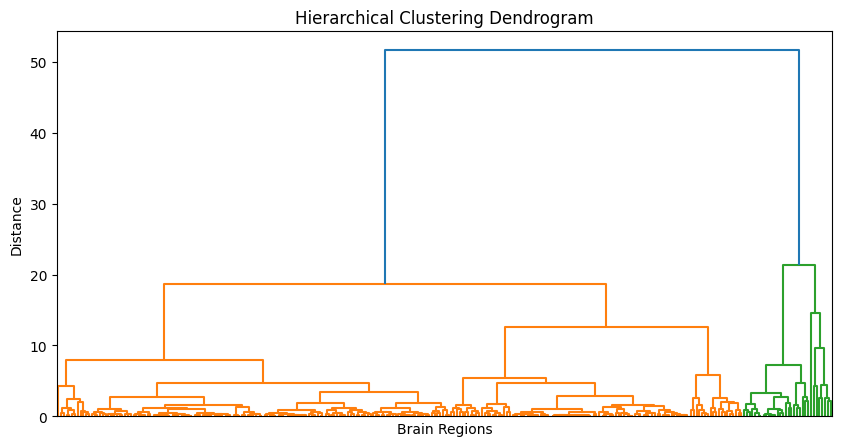

In [12]:
# Hierarchical Clustering (alternative)
linkage_matrix = linkage(effect_size_scaled, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, leaf_rotation=90, leaf_font_size=10, no_labels=True)  # Remove labels
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Brain Regions")
plt.ylabel("Distance")
plt.show()

### 3D and 2D PCA

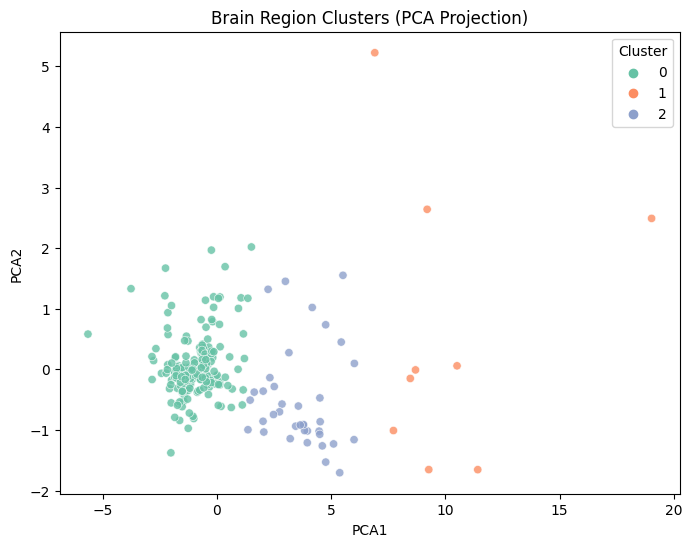

In [19]:

# Visualize clusters using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(effect_size_scaled)
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue=df["Cluster"], palette="Set2", data=df, alpha=0.8)
plt.title("Brain Region Clusters (PCA Projection)")
plt.show()


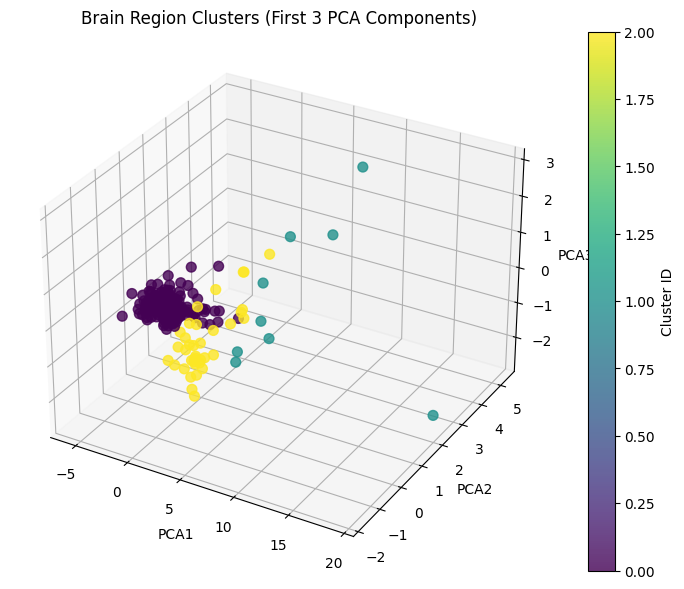

In [20]:
# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3)
pca_result = pca.fit_transform(effect_size_scaled)

# Add PCA components to DataFrame
df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]
df["PCA3"] = pca_result[:, 2]

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on cluster assignment
scatter = ax.scatter(df["PCA1"], df["PCA2"], df["PCA3"], c=df["Cluster"], cmap="viridis", s=50, alpha=0.8)

# Labels and title
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.set_title("Brain Region Clusters (First 3 PCA Components)")

# Color bar
plt.colorbar(scatter, ax=ax, label="Cluster ID")

# Show the plot
plt.show()

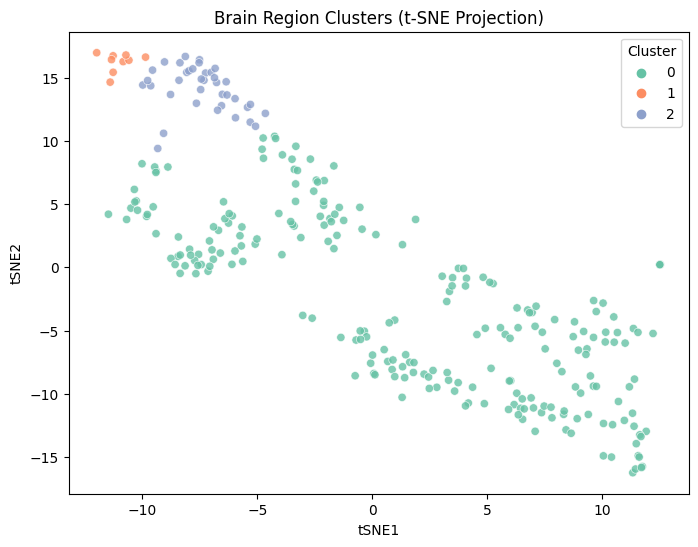

In [21]:
from sklearn.manifold import TSNE

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(effect_size_scaled)

# Add t-SNE results to the dataframe
df["tSNE1"] = tsne_result[:, 0]
df["tSNE2"] = tsne_result[:, 1]

# Visualize clusters using t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x="tSNE1", y="tSNE2", hue=df["Cluster"], palette="Set2", data=df, alpha=0.8)
plt.title("Brain Region Clusters (t-SNE Projection)")
plt.show()